In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from collections import defaultdict
import numba as nb
from skimage.morphology import label
from scipy.ndimage import measurements
from matplotlib.patches import Rectangle
import sys


In [2]:
# Tried to use brute force building up the polyomino from 1 and placing
# all possible polyominos but that got huge quickly
# stumbled on this solution in C++ 
# https://github.com/AnthonyDas/JaneStreet_Subtiles_Oct2018/blob/master/JaneStreet_Subtiles_Oct2018/
# which uses the fact the 9s need to connect in a certain way to then
# work out the other forced cells and then work through the other options
# [his solution is much more automated than mine and I've borrowed a lot of the methodology]
# Once you get those 9's placed it really cuts down the options.
# Numba really helped... about a 50x speed up !

url='https://www.janestreet.com/puzzles/subtiles//'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:19]))

Place an integer between 1 and 17 into some of the empty cells in the grid. When completed, the grid should have one 1, two 2’s, etc., up to seventeen 17’s. Furthermore, for all N larger than 1, the squares marked N must form a connected N -omino whose shape “contains” the ( N −1)-omino determined by the ( N −1)’s. (Reflections and rotations are allowed.) Some of the cells have already been labeled. The answer to this puzzle is the product of the areas of the empty regions in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/10/20181001_subtiles.png" width="350" >

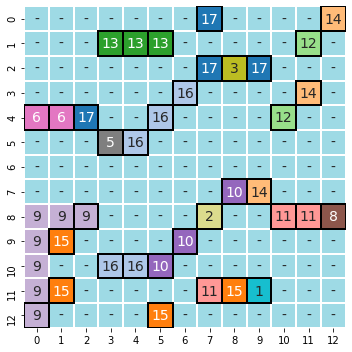

In [136]:
# set up the groups
orig = np.array([[ 0,  0,  0,  0,  0,  0,  0, 17,  0,  0,  0,  0, 14],
                 [ 0,  0,  0, 13, 13, 13,  0,  0,  0,  0,  0, 12,  0],
                 [ 0,  0,  0,  0,  0,  0,  0, 17,  3, 17,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0, 14,  0],
                 [ 6,  6, 17,  0,  0, 16,  0,  0,  0,  0, 12,  0,  0],
                 [ 0,  0,  0,  5, 16,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, 10, 14,  0,  0,  0],
                 [ 0,  0,  9,  0,  0,  0,  0,  2,  0,  0, 11, 11,  8],
                 [ 0, 15,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0, 16, 16, 10,  0,  0,  0,  0,  0,  0,  0],
                 [ 0, 15,  0,  0,  0,  0,  0, 11, 15,  1,  0,  0,  0],
                 [ 9,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0]],dtype=int)

def grid_print(grid):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((grid).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(grid,annot=x,cbar=False,cmap="tab20_r",fmt="",linewidths=1,ax=ax,annot_kws={"size":14})
    for i,j in itertools.product(range(13),range(13)):
        if orig[i,j]>0:
            ax.add_patch(Rectangle((j,i), 1, 1, fill=False, edgecolor='k', lw=2))
    plt.tight_layout()   
    plt.show()
    
# The 9s must be here to stop the 15s being cut off
fixed = dcopy(orig)
fixed[8:13,0] = 9
fixed[8,1] = 9
grid_print(fixed)

In [138]:
# create the n-ominos to place
# -work out the range of cells the n-omino is in
# -create a smaller grid n-omino to use later
# -generate all the rotations and reflections 
#  for that n-omino

@nb.njit
def span(grid,number):
    x_min = 13
    x_max = 0
    y_min = 13
    y_max = 0
    for i in range(13):
        if number in grid[i,:]:
            x_min = min(x_min,i)
            x_max = max(x_max,i)
        if number in grid[:,i]:
            y_min = min(y_min,i)
            y_max = max(y_max,i)
            
    x_span = x_max - x_min + 1
    y_span = y_max - y_min + 1
    
    return grid,number,x_span,y_span,x_min,x_max,y_min,y_max

@nb.njit
def create_test_grid(grid,test_grid,number):
    grid,number,x_span,y_span,x_min,x_max,y_min,y_max=span(grid,number)
    test_grid = test_grid[x_min:x_max+1,y_min:y_max+1]
    for i in range(x_span):
        for j in range(y_span):
            if test_grid[i,j] !=number and test_grid[i,j] >0:
                test_grid[i,j] = -1
    return test_grid


def create_rotations(test_grid):
    rotations = [test_grid]
    for i in range(4):
        a = np.rot90(test_grid,i)
        b = np.flip(np.rot90(test_grid,i),0)
        if all(not np.array_equal(a,x) for x in rotations):
            rotations.append(a)
        if all(not np.array_equal(b,x) for x in rotations):
            rotations.append(b)
        
    return(rotations)

In [139]:
# checks to see if a possible grid is valid
@nb.njit
def test_grid(grid,new_number):

    if np.sum(np.ravel(grid)==new_number) > new_number:
        return False
        
    grid,number,x_span,y_span,x_min,x_max,y_min,y_max = span(grid,new_number)
    if (x_span + y_span - 1) > new_number:
        return False
    
    return True

In [140]:
# check the placements of an n-omnio that match with the next higher number

@nb.njit
def check_placements(rotation,grid,number,next_number):
    size = rotation.shape
    possible_grids =[]
    #loop through the grid
    for grid_i in range(13-size[0]+1):
        for grid_j in range(13-size[1]+1):
        
        #loop through the test cell
            valid = True
            exception_count = 0
            poss_grid = grid.copy()
            for test_i in range(size[0]):
                for test_j in range(size[1]):
                    if valid == False:
                        continue
                    if (rotation[test_i,test_j] ==number) & (grid[grid_i+test_i,grid_j+test_j] == 0):
                        poss_grid[grid_i+test_i,grid_j+test_j] = next_number
                        continue
                        
                    elif (rotation[test_i,test_j] ==number) & (grid[grid_i+test_i,grid_j+test_j] != next_number):
                        valid = False
                        continue
                        
                    if rotation[test_i,test_j] ==-1 & grid[grid_i+test_i,grid_j+test_j] == next_number:
                        exception_count += 1
                        if exception_count > (next_number - number):
                            valid = False
                            continue
                                
            if valid:
                if test_grid(poss_grid,next_number):
                    possible_grids.append(poss_grid)
                
    return possible_grids

def areas(grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))

        return np.prod(areas)
           

In [144]:
#find the placements

def find_forced(grid,number,next_number):
    solutions = []
    test_grid =create_test_grid(grid,dcopy(grid),number)
    
    rotations = create_rotations(test_grid)
    poss_solutions = []
    
    for rotation in rotations:
        poss_solutions +=check_placements(rotation,grid,number,next_number)     
     
  
    if len(poss_solutions) ==0:
        return
    
    if next_number ==17:
        print("Num Solutions :",len(poss_solutions))
        print("The answer is :",areas(poss_solutions[0]))
        #print(np.unique(poss_solutions[0],return_counts=True)[1])
        grid_print(poss_solutions[0])
        
    else:
        for poss_solution in poss_solutions:
            find_forced(poss_solution,number+1,next_number+1)

Num Solutions : 1
The answer is : 256.0


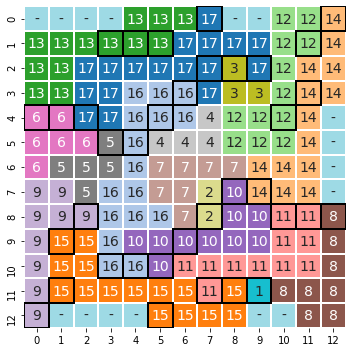

Took 1.02326250 seconds


In [155]:
start =time.time()
fixed = dcopy(orig)

#stop the 15 getting landlocked
fixed[8:13,0] = 9
fixed[8,1] = 9

#just limiting a few choices gives a lot more clarity
# I start with seeing what is forced by the 9's
# and go from there
#find_forced(fixed,9,10) 

#then the 14 in the corner needs to be linked this way
fixed[:4,12] =14

#fixed[12,1] =9 (gives no solutions)
#fixed[7,2] =9 (gives no solutions)
fixed[7,:2]=9

#the 6 and 5 have to be like this
#from fixed[5,2] =6
fixed[5,:3] =6
fixed[6,0] =6
fixed[6,1:4] = 5
fixed[7,2] =5

#the only place the last 12 can go is
fixed[0,11]=12

#to get to the 14 the 13 has to be
fixed[0,6] =13

#this is the only place the last 15 fits
fixed[12,5] =15

#the 8 must be here
fixed[8:13,12]=8
fixed[3,8]=3

#try both of the placements for the 2
fixed[7,7]=2

#then it's just fitting the last 16 and the 7 and 4
fixed[8,5]=16 #other placements give no options
fixed[3,9]=3 #this is then fixed

# then there only one option for the 7 that leave space for a 4 and the extra 7
fixed[5,5:8]=4
#the last 7 is missing and must be here
fixed[6,8]=7


# If I start from 1 I get 4 identical solutionsm as you can get to the 2 and 3 in 2 different ways. From
# there each following tile has only one placement that fits !
find_forced(fixed,3,4)
print("Took {:,.8f} seconds".format(time.time()-start))    

In [37]:
url='https://www.janestreet.com/puzzles/solutions/october-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The unique configuration that satisfies the “sub-tiles” property is shown to the left, and the product of the areas of the empty regions is 256 . Congrats to this month’s solvers!


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/11/20181031_subtiles_ans.png" width="350" >

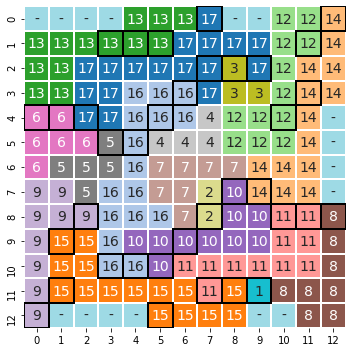

counts = [16  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [152]:
soln = np.array([[ 0,  0,  0,  0, 13, 13, 13, 17,  0,  0, 12, 12, 14],
                 [13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 12, 12, 14],
                 [13, 13, 17, 17, 17, 17, 17, 17,  3, 17, 12, 14, 14],
                 [13, 13, 17, 17, 16, 16, 16, 17,  3,  3, 12, 14, 14],
                 [ 6,  6, 17, 17, 16, 16, 16,  4, 12, 12, 12, 14,  0],
                 [ 6,  6,  6,  5, 16,  4,  4,  4, 12, 12, 12, 14,  0],
                 [ 6,  5,  5,  5, 16,  7,  7,  7,  7, 14, 14, 14,  0],
                 [ 9,  9,  5, 16, 16,  7,  7,  2, 10, 14, 14, 14,  0],
                 [ 9,  9,  9, 16, 16, 16,  7,  2, 10, 10, 11, 11,  8],
                 [ 9, 15, 15, 16, 10, 10, 10, 10, 10, 10, 11, 11,  8],
                 [ 9, 15, 15, 16, 16, 10, 11, 11, 11, 11, 11, 11,  8],
                 [ 9, 15, 15, 15, 15, 15, 15, 11, 15,  1,  8,  8,  8],
                 [ 9,  0,  0,  0,  0, 15, 15, 15, 15,  0,  0,  8,  8]],dtype=int)

grid_print(soln)
print("counts =",np.unique(soln,return_counts=True)[1])
